In [18]:
"""
===========================================
Drawing the AIA limb on a STEREO EUVI image
===========================================

In this example we use a STEREO-B and an SDO image to demonstrate how to
overplot the limb as seen by AIA on an EUVI-B image. Then we overplot the AIA
coordinate grid on the STEREO image.
"""
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from datetime import date


import sunpy.coordinates.wcs_utils
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

In [53]:
##############################################################################
# The first step is to download some data, we are going to get an image from
# early 2011 when the STEREO spacecraft were roughly 90 deg separated from the
# Earth.
stereo = (a.Source('STEREO_A') &
          a.Instrument("EUVI") &
          a.Time('2021-03-22', '2021-03-23T00:10:00'))

aia = (a.Instrument.aia &
       a.Sample(24 * u.hour) &
       a.Time('2021-03-22', '2021-03-23'))

wave = a.Wavelength(int(195)*u.angstrom)
result = Fido.search(wave, aia | stereo)

/Users/ato/anaconda3/lib/python3.7/site-packages/astropy/table/table.py:3183: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [54]:
###############################################################################
# Let's inspect the result
print(result)

Results from 1 Provider:

2 Results from the VSOClient:
       Start Time               End Time        ...             Info            
                                                ...                             
----------------------- ----------------------- ... ----------------------------
2021-03-22 00:00:00.000 2021-03-22 00:00:00.000 ... AIA level 1.5 NRT, 1024x1024
2021-03-23 00:00:00.000 2021-03-23 00:00:00.000 ... AIA level 1.5 NRT, 1024x1024




In [55]:
##############################################################################
# and download the files
downloaded_files = Fido.fetch(result)
print(downloaded_files)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

['/Users/ato/sunpy/data/aia20210322_000000_0193.fits', '/Users/ato/sunpy/data/aia20210323_000000_0193.fits']


In [56]:
##############################################################################
# Let's create a dictionary with the two maps, which we crop to full disk.
maps = {m.detector: m.submap(SkyCoord([-1100, 1100], [-1100, 1100],
                                      unit=u.arcsec, frame=m.coordinate_frame))
        for m in sunpy.map.Map(downloaded_files)}

In [57]:
##############################################################################
# Next, let's calculate points on the limb in the AIA image for the half that
# can be seen from STEREO's point of view.

r = maps['AIA'].rsun_obs - 1 * u.arcsec  # remove one arcsec so it's on disk.
# Adjust the following range if you only want to plot on STEREO_A
th = np.linspace(-180 * u.deg, 0 * u.deg)
x = r * np.sin(th)
y = r * np.cos(th)
coords = SkyCoord(x, y, frame=maps['AIA'].coordinate_frame)

KeyError: 'EUVI'

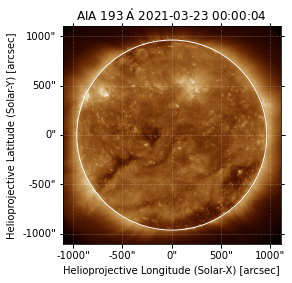

In [58]:
##############################################################################
# Now, let's plot both maps

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection=maps['AIA'])
maps['AIA'].plot(axes=ax1)
maps['AIA'].draw_limb()

ax2 = fig.add_subplot(1, 2, 2, projection=maps['EUVI'])
maps['EUVI'].plot(axes=ax2)
ax2.plot_coord(coords, color='w',ls="--", alpha=0.3)

In [ ]:
##############################################################################
# Let's also plot the helioprojective coordinate grid as seen by SDO on the
# STEREO image.

fig = plt.figure()
ax = plt.subplot(projection=maps['EUVI'])

maps['EUVI'].plot()

# Move the title so it does not clash with the extra labels.
tx, ty = ax.title.get_position()
ax.title.set_position([tx, ty + 0.08])

In [12]:
# Change the default grid labels.
stereo_x, stereo_y = ax.coords
stereo_x.set_axislabel("Helioprojective Longitude (STEREO B) [arcsec]")
stereo_y.set_axislabel("Helioprojective Latitude (STEREO B) [arcsec]")

In [14]:
# Add a new coordinate overlay in the SDO frame.
overlay = ax.get_coords_overlay(maps['AIA'].coordinate_frame)
overlay.grid()

# Configure the grid:
x, y = overlay

# Set the ticks to be on the top and left axes.
x.set_ticks_position('tr')
y.set_ticks_position('tr')

# Wrap the longitude at 180 deg rather than the default 360.
x.set_coord_type('longitude', 180.)

# Change the defaults to arcseconds
x.set_major_formatter('s.s')
y.set_major_formatter('s.s')

In [15]:
# Add axes labels
x.set_axislabel("Helioprojective Longitude (SDO) [arcsec]")
y.set_axislabel("Helioprojective Latitude (SDO) [arcsec]")
plt.show()